#import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split 
import re
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import itertools
from collections import Counter
from tensorflow.keras.preprocessing.text import Tokenizer
from  tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,LSTM,Dropout,GlobalAveragePooling1D,Embedding
from sklearn import metrics




#1- Load the dataset

In [2]:
data=pd.read_csv("train.csv")
test_data=pd.read_csv("test.csv")

In [3]:
test_data.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


#2- Check head and info of the data

In [4]:
data.head(20)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [5]:
data.describe(include="all")

,id,keyword,location,text,target
count,7613.000000,7552,5080,7613,7613.00000
unique,NaN,221,3341,7503,NaN
top,NaN,fatalities,USA,11-Year-Old Boy Charged With Manslaughter of T...,NaN
freq,NaN,45,104,10,NaN
mean,5441.934848,NaN,NaN,NaN,0.42966
std,3137.116090,NaN,NaN,NaN,0.49506
min,1.000000,NaN,NaN,NaN,0.00000
25%,2734.000000,NaN,NaN,NaN,0.00000
50%,5408.000000,NaN,NaN,NaN,0.00000
75%,8146.000000,NaN,NaN,NaN,1.00000


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


#3- Is there a missing data [how many and the percentage if there]?

In [7]:
missing_data=data.isna().sum()
print(f"number of missing data = \n\n{missing_data}")


number of missing data = 

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


In [8]:
percentage_missing_data=data.isna().mean()
print(f"percentage of missing data = \n\n{percentage_missing_data}")


percentage of missing data = 

id          0.000000
keyword     0.008013
location    0.332720
text        0.000000
target      0.000000
dtype: float64


#4- How many data in each class?

In [9]:
count_data=data["target"].value_counts()
print(count_data)

0    4342
1    3271
Name: target, dtype: int64


#5- Get the top 15 locations of the data

In [10]:
keyword_freq=data["keyword"].value_counts().head(15)
print(keyword_freq)

fatalities     45
deluge         42
armageddon     42
sinking        41
damage         41
harm           41
body%20bags    41
outbreak       40
evacuate       40
fear           40
collided       40
siren          40
twister        40
windstorm      40
sinkhole       39
Name: keyword, dtype: int64


In [11]:
type(count_data)

pandas.core.series.Series

#6- Get the top 15 keyword in the data

In [12]:
location_freq=data["location"].value_counts().head(15)
print(location_freq)

USA                104
New York            71
United States       50
London              45
Canada              29
Nigeria             28
UK                  27
Los Angeles, CA     26
India               24
Mumbai              22
Washington, DC      21
Kenya               20
Worldwide           19
Australia           18
Chicago, IL         18
Name: location, dtype: int64


In [13]:
data['location'] = data['location'].fillna("none")


In [14]:
train_data=data["text"]
print(type(train_data))
train_data.head(50)

<class 'pandas.core.series.Series'>


0     Our Deeds are the Reason of this #earthquake M...
1                Forest fire near La Ronge Sask. Canada
2     All residents asked to 'shelter in place' are ...
3     13,000 people receive #wildfires evacuation or...
4     Just got sent this photo from Ruby #Alaska as ...
5     #RockyFire Update => California Hwy. 20 closed...
6     #flood #disaster Heavy rain causes flash flood...
7     I'm on top of the hill and I can see a fire in...
8     There's an emergency evacuation happening now ...
9     I'm afraid that the tornado is coming to our a...
10          Three people died from the heat wave so far
11    Haha South Tampa is getting flooded hah- WAIT ...
12    #raining #flooding #Florida #TampaBay #Tampa 1...
13              #Flood in Bago Myanmar #We arrived Bago
14    Damage to school bus on 80 in multi car crash ...
15                                       What's up man?
16                                        I love fruits
17                                     Summer is

In [15]:
#getting labels of data 
train_label=data["target"]
train_label.head()

0    1
1    1
2    1
3    1
4    1
Name: target, dtype: int64

In [16]:
x_test=test_data["text"]
x_test.head(50)

0                    Just happened a terrible car crash
1     Heard about #earthquake is different cities, s...
2     there is a forest fire at spot pond, geese are...
3              Apocalypse lighting. #Spokane #wildfires
4         Typhoon Soudelor kills 28 in China and Taiwan
5                    We're shaking...It's an earthquake
6     They'd probably still show more life than Arse...
7                                     Hey! How are you?
8                                      What a nice hat?
9                                             Fuck off!
10                                No I don't like cold!
11                           NOOOOOOOOO! Don't do that!
12                               No don't tell me that!
13                                            What if?!
14                                             Awesome!
15    Birmingham Wholesale Market is ablaze BBC News...
16    @sunkxssedharry will you wear shorts for race ...
17    #PreviouslyOnDoyinTv: Toke MakinwaÛªs mar

#8- What are the most common stop words?

In [17]:
stemmer=PorterStemmer()
nltk.download("stopwords")
stop_words=stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

#9- Use nlp to prepare dataset 

In [19]:
def pre_processin(tweets):
    clean_tweets=[]
    count_l=[]
    vocub=""
    stemmer=PorterStemmer()
    for tweet in tweets:
        tweet=re.sub("(#|@)[a-zA-Z0-9_]*","",tweet) # remove hash& mention
        tweet=re.sub("https?:\/\/\S+","",tweet)# remove hyperlink
        tweet=re.sub("\W"," ",tweet) 
        # tweet=re.sub("\s+\d+\s+"," ",tweet)# remove digits 
        tweet=re.sub("^\s+","",tweet)# remove spacei in first
        tweet=re.sub("\s+$","",tweet)
        # tweet=re.sub("\d+", "", tweet)# to remove numbers
        tweet=re.sub("(\xe9|\362)","",tweet) # to remove Unicode characters
        tweet =re.sub("\s+[a-zA-Z]\s+", "", tweet) # to remove single letter
        tweet = re.sub("[^a-zA-Z+']"," ",tweet)  # to keep char
        # remove stops words & stemmer    
        clean_tweet=[stemmer.stem(word)  for word in tweet.split() if word.lower() not in stop_words  ]      
        # append clean tweet
        clean_tweets.append(clean_tweet)

    return clean_tweets 


In [ ]:
train_data=pre_processin(train_data)
x_test=pre_processin(x_test)


In [21]:
# getting number of different words in data after cleaning 
mixed_list=list(itertools.chain.from_iterable(train_data)) #to mix all train data emement to check length
mixed_list_2=list( dict.fromkeys(mixed_list) )# convet to dict to remove duplication
counter_=(len(mixed_list_2))
print(counter_)
print(mixed_list_2)

13074
['deed', 'reason', 'may', 'allah', 'forgiv', 'us', 'forest', 'fire', 'near', 'La', 'rong', 'sask', 'canada', 'resid', 'ask', 'shelter', 'place', 'notifi', 'offic', 'evacu', 'order', 'expect', 'peopl', 'receiv', 'california', 'got', 'sent', 'photo', 'rubi', 'smoke', 'pour', 'intoschool', 'updat', 'hwi', 'close', 'direct', 'due', 'lake', 'counti', 'heavi', 'rain', 'caus', 'flash', 'flood', 'street', 'manit', 'colorado', 'spring', 'area', 'ion', 'top', 'hill', 'andcan', 'seefir', 'wood', 'therean', 'emerg', 'happen', 'build', 'across', 'iafraid', 'tornado', 'come', 'three', 'die', 'heat', 'wave', 'far', 'haha', 'south', 'tampa', 'get', 'hah', 'waitsecondl', 'amgonna', 'fvck', 'daysv', 'lost', 'count', 'bago', 'myanmar', 'arriv', 'damag', 'school', 'bu', 'multi', 'car', 'crash', 'whatup', 'man', 'love', 'fruit', 'summer', 'fast', 'whatgoooooooaaaaaal', 'ridicul', 'london', 'cool', 'ski', 'whatwond', 'day', 'looooool', 'waycaneat', 'shit', 'nyc', 'last', 'week', 'girlfriend', 'cooool'

#7- What are the most common words?

In [22]:

def most_frequent(List):
    occurence_count = Counter(List)
    return occurence_count.most_common(15)
   
print(f"the most 15 common words in data set \n {most_frequent(mixed_list)}")

the most 15 common words in data set 
 [('fire', 337), ('amp', 320), ('new', 273), ('get', 247), ('like', 234), ('bomb', 215), ('via', 210), ('one', 200), ('peopl', 190), ('kill', 178), ('burn', 166), ('go', 165), ('year', 163), ('time', 162), ('emerg', 158)]


In [23]:
# getting length of longest tweet 
longest_list = max(len(elem) for elem in train_data)
print(longest_list)


21


In [24]:
#applying tokenizer
tokenizer=Tokenizer(num_words= counter_) 

In [25]:
tokenizer.fit_on_texts(train_data)
sequences=tokenizer.texts_to_sequences(train_data)

In [26]:
print(sequences)

[[3394, 440, 82, 2257, 2711, 34], [170, 1, 158, 504, 4929, 4930, 1271], [1272, 525, 1726, 378, 4931, 192, 27, 1726, 378, 267, 461], [9, 2712, 27, 267, 37], [62, 967, 131, 4932, 208, 2258, 4933], [184, 37, 1273, 268, 710, 379, 856, 289, 1], [641, 164, 58, 674, 17, 380, 4934, 909, 711, 144], [2713, 165, 1106, 3395, 4935, 1727], [4936, 15, 27, 187, 20, 675, 380], [4937, 402, 40, 144], [381, 9, 98, 228, 102, 462], [712, 363, 3396, 4, 17, 2714, 4938, 363, 3396, 3397, 3397, 4939], [4940, 544, 4941], [3398, 968, 676, 3398], [110, 125, 269, 2259, 56, 16], [4942, 51], [38, 1375], [302, 38], [56, 613], [4943], [1954], [857, 441], [38, 1376], [4944, 24], [4945], [4946, 193], [1274, 79, 290], [38, 1955], [4947], [5, 3399], [159], [2260, 241, 442], [279, 140, 443, 641], [242, 280, 2261, 505, 145, 442, 910], [677, 145, 442], [1377, 444, 25, 1376, 79, 217, 442], [1956, 132, 2262, 281, 3, 3400, 4948, 145, 4949, 442, 806], [3401, 192, 3402, 145, 442], [4950, 2263, 52, 56, 145, 442, 1728, 1189, 151, 234

In [27]:
#applying pad_sequences
train_data=pad_sequences(sequences,maxlen=longest_list)
train_data


array([[   0,    0,    0, ..., 2257, 2711,   34],
       [   0,    0,    0, ..., 4929, 4930, 1271],
       [   0,    0,    0, ...,  378,  267,  461],
       ...,
       [   0,    0,    0, ...,  753,  457, 1265],
       [   0,    0,    0, ...,   84,  836,   85],
       [   0,    0,    0, ...,  121,  606,    3]], dtype=int32)

#10- Prepare train, test sets

In [28]:
#splitting data into train and validation sets 
X_train, X_test,y_train, y_test = train_test_split(train_data,train_label,test_size=0.2)

#11- Train your LSTM structure

In [29]:
#building model
model=Sequential()
model.add(Embedding(counter_,20,input_length=longest_list))
model.add(LSTM(100))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 21, 20)            261480    
                                                                 
 lstm (LSTM)                 (None, 100)               48400     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 32)                3232      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0

In [30]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [31]:
#fitting data 
history =model.fit(X_train,y_train, batch_size=32, 
                                  epochs=10,validation_data=(X_test, y_test),shuffle=1)

Epoch 1/10
191/191 [==============================] - 10s 20ms/step - loss: 0.5803 - accuracy: 0.6924 - val_loss: 0.4544 - val_accuracy: 0.8011
Epoch 2/10
191/191 [==============================] - 1s 6ms/step - loss: 0.3455 - accuracy: 0.8635 - val_loss: 0.4692 - val_accuracy: 0.8030
Epoch 3/10
191/191 [==============================] - 1s 6ms/step - loss: 0.2156 - accuracy: 0.9225 - val_loss: 0.5677 - val_accuracy: 0.7840
Epoch 4/10
191/191 [==============================] - 1s 7ms/step - loss: 0.1494 - accuracy: 0.9496 - val_loss: 0.6217 - val_accuracy: 0.7669
Epoch 5/10
191/191 [==============================] - 1s 6ms/step - loss: 0.1151 - accuracy: 0.9608 - val_loss: 0.7369 - val_accuracy: 0.7643
Epoch 6/10
191/191 [==============================] - 1s 7ms/step - loss: 0.0923 - accuracy: 0.9688 - val_loss: 0.8775 - val_accuracy: 0.7413
Epoch 7/10
191/191 [==============================] - 1s 7ms/step - loss: 0.0749 - accuracy: 0.9729 - val_loss: 0.8417 - val_accuracy: 0.7459
Epoc

#12- Evaluate the model and make predictions

In [32]:
#Evaluate the model
predicted = model.predict(X_test, verbose=1, batch_size=32)
score, test_accuracy = model.evaluate(X_test, y_test, batch_size=32)
y_predicted = [1 if out > 0.5 else 0 for out in predicted]

print("Test Accuracy: ", test_accuracy)
print(metrics.classification_report(list(y_test), y_predicted))



48/48 [==============================] - 0s 3ms/step - loss: 1.0703 - accuracy: 0.7505
Test Accuracy:  0.7504924535751343
              precision    recall  f1-score   support

           0       0.77      0.82      0.79       885
           1       0.72      0.65      0.69       638

    accuracy                           0.75      1523
   macro avg       0.75      0.74      0.74      1523
weighted avg       0.75      0.75      0.75      1523



In [33]:
#make predictions on test set 
sequences_test=tokenizer.texts_to_sequences(x_test)
print(sequences_test)
test_data=pad_sequences(sequences_test,maxlen=longest_list)

predicted_test = model.predict(test_data, verbose=1, batch_size=32)


[[56, 16], [1032, 791, 123, 330, 1165, 178], [1, 536, 2697, 2929, 675, 109], [387, 249], [161, 603, 10, 540, 1096], [1714, 4235, 359], [31, 173, 84, 2970, 1398, 2771, 2771], [509], [522], [90], [1058], [], [8919], [], [858], [2260, 241, 442, 1334, 3, 1, 242, 241], [1527, 1120, 2043, 442], [6345, 12121, 588, 145, 799, 343, 442], [209], [4116, 3419, 433, 235, 9696, 235], [3280, 54, 442, 9822, 2], [12, 51, 442, 7], [414, 9, 64, 116, 99, 1818, 4235, 284, 319, 663, 145, 219, 442], [1786, 556, 98, 145, 442, 13, 66, 197, 98, 12, 85, 145, 442], [145, 442], [1197, 759, 1862, 117, 145, 442, 24, 155, 491, 6966, 6739, 573], [442, 815], [12, 11867, 123, 2909, 11302, 1225, 2, 145, 442], [1007, 284, 442, 4242, 3110], [59, 1169, 2485, 3379, 1710, 35], [62, 38, 12, 294, 12369, 256, 94, 64, 307, 59, 3254], [555, 3243, 193, 59], [56, 705, 2746, 2809, 56, 3716, 489, 446, 311, 550, 59, 783], [6680, 31, 582, 326], [59, 158, 1069], [4696, 106, 95, 639, 2897, 59, 122], [2000, 1754, 83, 143, 34], [927, 2425, 2

#13- Evaluate the results with charts of acc and loss

Text(0.5, 1.0, 'loss')

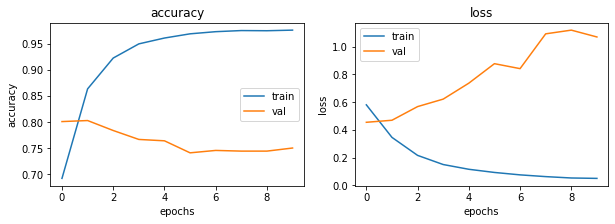

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))

for i, j in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[j])
    ax[i].plot(history.history['val_' + j])
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(j)
    ax[i].legend(['train', 'val']) 

ax[0].set_title('accuracy') 
ax[1].set_title('loss') 
   

#14- Save your model

In [35]:
model.save("Lstm_project.h5")